In [1]:
import datetime
import os
import pickle
import sys
sys.path.append("../")

import contextily as cx
from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
from shapely.geometry import Point, LineString, Polygon

from openbustools import data_utils, plotting, spatial, standardfeeds
importlib.reload(spatial)

<module 'openbustools.spatial' from '/Users/zackaemmer/Desktop/open_bus_tools/notebooks/../openbustools/spatial.py'>

In [2]:
# Load realtime and calendar, get service_ids for the date
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_19.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
valid_service_ids = standardfeeds.date_to_service_id('2023_05_19', "../data/kcm_gtfs/2023_05_14/")
# Create index of shapes (service/route/direction), merge with realtime
shape_lookup = standardfeeds.get_gtfs_shapes_lookup("../data/kcm_gtfs/2023_05_14/")
shapes = standardfeeds.get_gtfs_shapes("../data/kcm_gtfs/2023_05_14/").to_crs("EPSG:32148")
data_gtfsrt = data_gtfsrt.merge(shape_lookup, on='trip_id')
# Give geometry to realtime
data_gtfsrt = gpd.GeoDataFrame(data_gtfsrt, geometry=gpd.points_from_xy(data_gtfsrt.lon, data_gtfsrt.lat), crs="EPSG:4326").to_crs("EPSG:32148")
# Calculate avg metrics between GPS coordinates; drop first obs of every trip
data_gtfsrt['calc_time_s'], data_gtfsrt['calc_dist_m'] = spatial.calculate_gps_metrics(data_gtfsrt, 'locationtime')
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt['calc_speed_m_s'] = data_gtfsrt['calc_dist_m'] / data_gtfsrt['calc_time_s']
# Get rid of GPS drift
data_gtfsrt.loc[data_gtfsrt['calc_speed_m_s']<.05, 'calc_speed_m_s'] = 0

# First/last few points of every trip tend to have outliers
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(0).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)
data_gtfsrt = data_gtfsrt.drop(data_gtfsrt.groupby('trip_id', as_index=False).nth(-1).index)

# Filter out all trips with large outliers
mins_keep = 4
toss_speed_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_speed_m_s']>30]['trip_id'])
toss_dist_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_dist_m']>mins_keep*60*30]['trip_id'])
toss_time_trip_ids = list(data_gtfsrt[data_gtfsrt['calc_time_s']>mins_keep*60]['trip_id'])

toss_ids = []
toss_ids.extend(toss_speed_trip_ids)
toss_ids.extend(toss_dist_trip_ids)
toss_ids.extend(toss_time_trip_ids)
toss_ids = np.unique(toss_ids)
print(len(toss_ids) / len(np.unique(data_gtfsrt['trip_id'])))

print(len(data_gtfsrt))
data_gtfsrt = data_gtfsrt[~data_gtfsrt['trip_id'].isin(toss_ids)]
print(len(data_gtfsrt))

0.12536181255614331
723810
620146


In [3]:
# Get one shape to work with, filter realtime to all trips for that shape
sample_service_id, sample_route_id, sample_direction_id = data_gtfsrt.groupby(['service_id','route_id','direction_id']).count().index[42]
sample_realtime = data_gtfsrt[(data_gtfsrt['service_id']==sample_service_id) & (data_gtfsrt['route_id']==sample_route_id) & (data_gtfsrt['direction_id']==sample_direction_id)].copy()
# Finally get the corresponding shape from the static
sample_shape = shapes[(shapes['service_id']==sample_service_id) & (shapes['route_id']==sample_route_id) & (shapes['direction_id']==sample_direction_id)].copy()
# For all bus positions, get distance along line to nearest point on route shape
sample_realtime['dist_along_line'] = sample_realtime['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))
# Also get a timestamp column on the samples
sample_realtime['t'] = pd.to_datetime(sample_realtime['locationtime'], unit='s')
sample_realtime = sample_realtime.set_index('t')
sample_realtime

,trip_id,vehicle_id,lat,lon,orientation,scheduleDeviation,nextStop,locationtime,service_id,route_id,direction_id,geometry,calc_time_s,calc_dist_m,calc_speed_m_s,dist_along_line
t,,,,,,,,,,,,,,,,
2023-05-19 20:39:00,473762803,8140,47.47066879272461,-122.3338623046875,89.73179468191643,183,47740,1684528740,21133,100031,1,POINT (386888.377 53432.864),40.0,214.794000,5.369850,257.125378
2023-05-19 20:39:20,473762803,8140,47.471649169921875,-122.33385467529297,89.73179468191643,195,47740,1684528760,21133,100031,1,POINT (386891.077 53541.831),20.0,109.000481,5.450024,336.185614
2023-05-19 20:39:40,473762803,8140,47.471649169921875,-122.33385467529297,89.73179468191643,215,47740,1684528780,21133,100031,1,POINT (386891.077 53541.831),20.0,0.000000,0.000000,336.185614
2023-05-19 20:40:37,473762803,8140,47.47224044799805,-122.33385467529297,89.73179468191643,254,47740,1684528837,21133,100031,1,POINT (386892.359 53607.557),57.0,65.738673,1.153310,383.627736
2023-05-19 20:41:32,473762803,8140,47.47236251831055,-122.3279037475586,0.38517590885943087,265,49356,1684528892,21133,100031,1,POINT (387341.140 53612.397),55.0,448.807512,8.160137,826.369509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19 13:26:01,559807353,8001,47.610286712646484,-122.3382797241211,131.98721249592913,21,590,1684502761,21133,100031,1,POINT (386858.970 68959.201),30.0,240.601662,8.020055,20200.608256
2023-05-19 13:26:22,559807353,8001,47.61082077026367,-122.33877563476562,132.49594915817195,-4,590,1684502782,21133,100031,1,POINT (386822.854 69019.295),21.0,70.112374,3.338684,20270.719899
2023-05-19 13:26:48,559807353,8001,47.61151123046875,-122.33942413330078,133.97084519648203,-4,600,1684502808,21133,100031,1,POINT (386775.609 69097.001),26.0,90.940323,3.497705,20362.084267


<Axes: xlabel='calc_speed_m_s', ylabel='Count'>

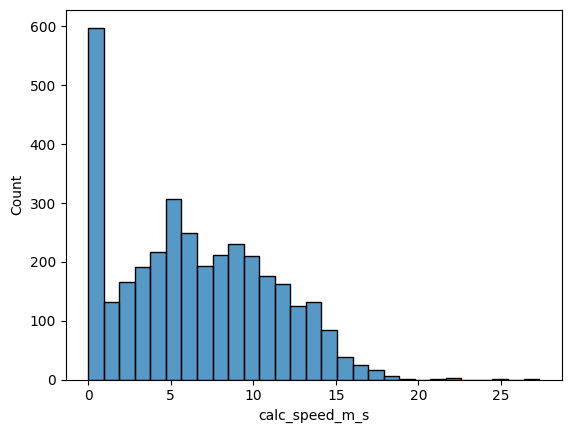

In [4]:
sns.histplot(sample_realtime['calc_speed_m_s'])

<Axes: xlabel='calc_dist_m', ylabel='Count'>

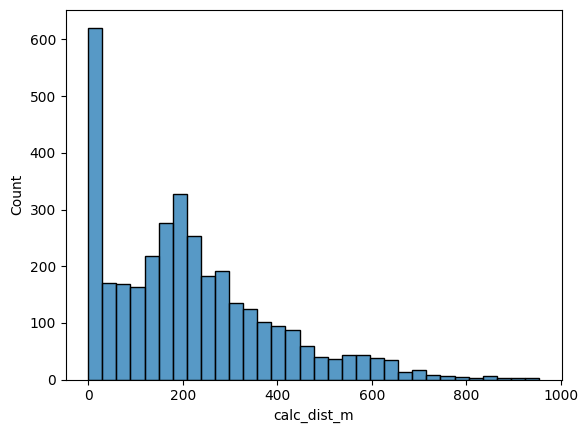

In [5]:
sns.histplot(sample_realtime['calc_dist_m'])

<Axes: xlabel='calc_time_s', ylabel='Count'>

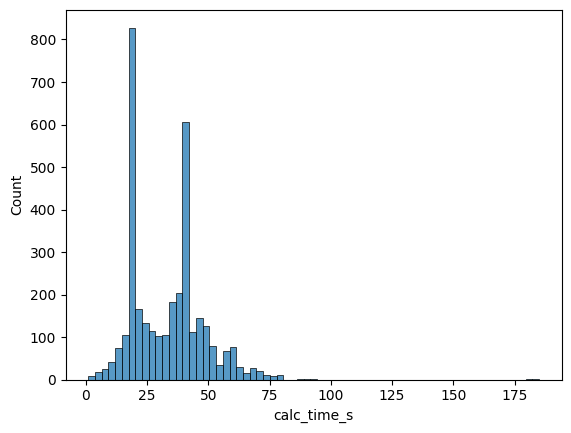

In [6]:
sns.histplot(sample_realtime['calc_time_s'])

In [112]:
# onetrip = sample_realtime[sample_realtime['trip_id']==sample_realtime.sample(1)['trip_id'].values[0]].copy()
# onetrip['smooth_speed_m_s'] = onetrip['calc_speed_m_s'].rolling(3, min_periods=1).mean()
# axes = sns.lineplot(onetrip, x='t', y='calc_speed_m_s')
# sns.lineplot(onetrip, x='t', y='smooth_speed_m_s', ax=axes)

# axes = sns.lineplot(onetrip, x='t', y='calc_speed_m_s')
# onetrip_re = onetrip[['calc_speed_m_s']].resample('S').bfill().rolling(120, min_periods=1).mean()
# sns.lineplot(onetrip_re, x='t', y='calc_speed_m_s', ax=axes)

In [125]:
sample_ids = sample_realtime['trip_id'].sample(10).values
sample_trips = sample_realtime[sample_realtime['trip_id'].isin(sample_ids)]
plot_df = sample_trips[['trip_id','calc_speed_m_s','dist_along_line']].groupby('trip_id').resample('S').bfill().rolling(6, min_periods=1).mean()
plot_df

trip_id  calc_speed_m_s  dist_along_line
trip_id   t                                                                
473762963 2023-05-19 21:06:48  473762963.0        1.707643       383.627736
          2023-05-19 21:06:49  473762963.0        5.925873       613.911478
          2023-05-19 21:06:50  473762963.0        7.331950       690.672726
          2023-05-19 21:06:51  473762963.0        8.034988       729.053349
          2023-05-19 21:06:52  473762963.0        8.456811       752.081724
...                                    ...             ...              ...
559807353 2023-05-19 13:27:24  559807353.0        3.841678     20559.076507
          2023-05-19 13:27:25  559807353.0        3.841678     20559.076507
          2023-05-19 13:27:26  559807353.0        3.841678     20559.076507
          2023-05-19 13:27:27  559807353.0        3.841678     20559.076507
          2023-05-19 13:27:28  559807353.0        3.841678     20559.076507

[27200 rows x 3 columns]

<Axes: xlabel='dist_along_line', ylabel='calc_speed_m_s'>

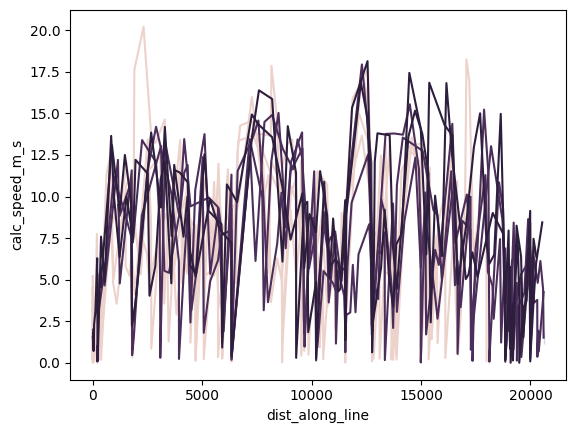

In [124]:
sns.lineplot(plot_df, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)

<Axes: xlabel='dist_along_line', ylabel='calc_speed_m_s'>

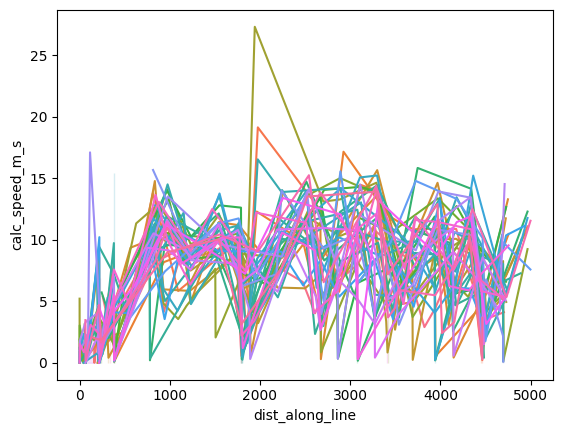

In [11]:
sns.lineplot(sample_realtime[sample_realtime['dist_along_line']<5000], x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)

In [ ]:
# Final units of analysis are for all service_id/route_id/direction_id; uniquely identifies a shape
# we have many corresponding trips;
# we use these, or static files, or OSM, or  to construct the route geometry
# then we can recreate "distance along trip" for individual observations

# Start from a single route + direction
# There will be many trips observed in single daily realtime file

### Trip GPS Points

In [ ]:
data_phone = pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_validation_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, data_phone['calc_speed_m_s'] = spatial.calculate_speed(data_phone, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(data_phone, "Phone Basemap")

In [ ]:
data_gtfs = data_utils.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
gtfs_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
filtered_gtfs, remaining_trip_ids = data_utils.filter_gtfs_w_phone(data_phone, data_gtfs, short_name, gtfs_calendar)
filtered_gtfs = gpd.GeoDataFrame(filtered_gtfs, geometry=gpd.points_from_xy(filtered_gtfs.stop_lon, filtered_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfs['seconds_elapsed'] = filtered_gtfs['arrival_s'] - filtered_gtfs['arrival_s'].iloc[0]
_, _, filtered_gtfs['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfs, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(filtered_gtfs, "GTFS Basemap")

In [ ]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_20.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
filtered_gtfsrt_daily = data_gtfsrt[data_gtfsrt['trip_id'].isin(remaining_trip_ids)]
filtered_gtfsrt_one = filtered_gtfsrt_daily[filtered_gtfsrt_daily['trip_id']==remaining_trip_ids[0]]
filtered_gtfsrt_one = gpd.GeoDataFrame(filtered_gtfsrt_one, geometry=gpd.points_from_xy(filtered_gtfsrt_one.lon, filtered_gtfsrt_one.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_one['seconds_elapsed'] = filtered_gtfsrt_one['locationtime'] - filtered_gtfsrt_one['locationtime'].iloc[0]
_, _, filtered_gtfsrt_one['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_one, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_one, "GTFS-RT Basemap One Trip")

In [ ]:
filtered_gtfsrt_daily = gpd.GeoDataFrame(filtered_gtfsrt_daily, geometry=gpd.points_from_xy(filtered_gtfsrt_daily.lon, filtered_gtfsrt_daily.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_daily['seconds_elapsed'] = filtered_gtfsrt_daily['locationtime'] - filtered_gtfsrt_daily['locationtime'].iloc[0]
_, _, filtered_gtfsrt_daily['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_daily, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_daily, "GTFS-RT Basemap Daily Trips")

### Drive Cycles

In [ ]:
data_melt_phone = pd.melt(data_phone, id_vars=['seconds_elapsed'], value_vars=['speed','calc_speed_m_s','altitudeAboveMeanSeaLevel'])
plotting.formatted_rel_lineplot(data_melt_phone, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='Phone Speed')

In [ ]:
filtered_melt_gtfs = pd.melt(filtered_gtfs, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfs, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS Speed', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_one = pd.melt(filtered_gtfsrt_one, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_one, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle One Trip', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_daily = pd.melt(filtered_gtfsrt_daily, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_daily, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle Daily Trips')